In [1]:
import findspark
findspark.init()
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

# 문제 1의 답

In [2]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [3]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


# 문제 2 시작

In [4]:
x=iris['petal_length']
y=iris['petal_width']

In [5]:
import numpy as np
x=np.array([x,np.ones(len(x))])
x=x.T

In [6]:
w1, w0=np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T, y))

In [7]:
yhat = w0*x[:,1] + w1*x[:,0]

# 문제 2의 답

Text(0.5, 0, 'petal_length')

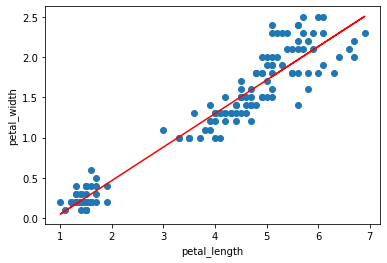

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(x[:,0],y)
plt.plot(x[:,0],yhat,'r-')
ax.set_ylabel('petal_width') 
ax.set_xlabel('petal_length')

# 문제 3 시작

In [32]:
irisDf=spark.createDataFrame(iris)

In [33]:
irisDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [34]:
(trainDf, testDf) = irisDf.randomSplit([0.6, 0.4])

In [35]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["sepal_length"],
                                   outputCol = 'features')

In [36]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='petal_width')

In [37]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[va,lr])

In [38]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

# 문제 3의 답

In [39]:
print("계수: {}".format(lr_model.coefficients))
print("절편: {:.2f}".format(lr_model.intercept)) #y절편

계수: [0.7904606847210116]
절편: -3.43


# 문제 4 시작

In [40]:
modelTestDf=model.transform(testDf)

In [44]:
modelTestDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [41]:
modelTestDf.select('petal_width','prediction').show(10)

+-----------+-------------------+
|petal_width|         prediction|
+-----------+-------------------+
|        0.2|0.21522289269743577|
|        0.2|0.21522289269743577|
|        0.3| 0.2856154620873492|
|        0.2| 0.3560080314772627|
|        0.3| 0.3560080314772627|
|        0.2|   0.49679317025709|
|        0.2|   0.49679317025709|
|        0.2| 0.5671857396470039|
|        0.1| 0.5671857396470039|
|        0.1| 0.5671857396470039|
+-----------+-------------------+
only showing top 10 rows



In [45]:
feature=modelTestDf.rdd.map(lambda x:x[3]).collect()
pred=modelTestDf.rdd.map(lambda x:x[6]).collect()

# 문제 4의 답

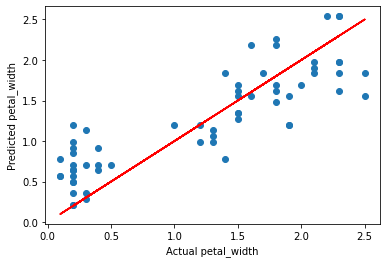

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(feature,pred)
ax.set_ylabel('Predicted petal_width') 
ax.set_xlabel('Actual petal_width')
ax.plot(feature,feature,'r')

# 문제 5 시작

In [48]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="rmse")

In [49]:
rmse=evaluator.evaluate(modelTestDf)

# 문제 5의 답

In [51]:
print("RMSE on test data: {}".format(rmse))

RMSE on test data: 0.4288862592059988
